In [30]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root

#mpl.rcParams['figure.figsize'] = 6.2,3.5
#mpl.rcParams['axes.labelsize'] = 17
#mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['lines.markersize'] = 6
#mpl.rcParams['legend.fontsize']= 15



mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})

In [2]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyHadronCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    #dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<1.25', ' 1.0 <Q2<1.25 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5 and Nu<4.0',  ' 3.5 <Nu<4.0')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'P >0.2 ', 'P>0.2 ')

    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyElectronCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    #dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<1.25', ' 1.0 <Q2<1.25 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5 and Nu<4.0',  ' 3.5 <Nu<4.0')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe





In [3]:
def getRatio(df_A,df_D,df_electron_A,df_electron_D, variable='z',event_cut='Q2>1.0',hadron_cut = ' and P>0',minz=0.05,maxz=1.0,nbins=9):
    
    
    norm_A = df_electron_A.query(event_cut).shape[0]
    norm_D = df_electron_D.query(event_cut).shape[0]
    print 'Number of electron A', norm_A
    print 'Number of electron D', norm_D
    
    y_A, x_conditional = np.histogram(df_A.query(event_cut+hadron_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(event_cut+hadron_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

## Get data from Ntuples to dataframes

In [4]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

In [5]:
df = {}

## GiBUU 

In [6]:
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print target
    print ' hadron'
    df['GiBUU_%s_hadron'%target]= getdatainChunks('GiBUU_SingleHadron_%s.root'%target, '%s_hadron'%target)
    print ' electron'
    df['GiBUU_%s_electron'%target]= getdatainChunks('GiBUU_SingleHadron_%s.root'%target,'%s_electron'%target)
print df.keys()

D
 hadron
1336569
 electron
1000001
C
 hadron
1453239
 electron
1000001
Fe
 hadron
1509986
 electron
1000001
Pb
 hadron
1555718
 electron
1000001
['GiBUU_Fe_hadron', 'GiBUU_Pb_electron', 'GiBUU_C_hadron', 'GiBUU_Pb_hadron', 'GiBUU_D_hadron', 'GiBUU_Fe_electron', 'GiBUU_D_electron', 'GiBUU_C_electron']


In [7]:
print df.keys()

['GiBUU_Fe_hadron', 'GiBUU_Pb_electron', 'GiBUU_C_hadron', 'GiBUU_Pb_hadron', 'GiBUU_D_hadron', 'GiBUU_Fe_electron', 'GiBUU_D_electron', 'GiBUU_C_electron']


In [8]:
for target in ['D','C','Fe','Pb']:
    print target
    df['GiBUU_%s_electron'%target] = applyElectronCuts(df['GiBUU_%s_electron'%target], isMC=True)
    df['GiBUU_%s_hadron'%target] = applyHadronCuts(df['GiBUU_%s_hadron'%target], isMC=True)
    print ' ' 


D
Entries before cut  1000001
inelasticity < 0.85 1000001  (100.00  %)
Entries before cut  1336569
P<2.5  1217391  (91.08  %)
P>0.2  1100514  (90.40  %)
inelasticity < 0.85 1100514  (100.00  %)
 
C
Entries before cut  1000001
inelasticity < 0.85 1000001  (100.00  %)
Entries before cut  1453239
P<2.5  1356528  (93.35  %)
P>0.2  1121899  (82.70  %)
inelasticity < 0.85 1121899  (100.00  %)
 
Fe
Entries before cut  1000001
inelasticity < 0.85 1000001  (100.00  %)
Entries before cut  1509986
P<2.5  1434822  (95.02  %)
P>0.2  1074531  (74.89  %)
inelasticity < 0.85 1074531  (100.00  %)
 
Pb
Entries before cut  1000001
inelasticity < 0.85 1000001  (100.00  %)
Entries before cut  1555718
P<2.5  1498238  (96.31  %)
P>0.2  1013832  (67.67  %)
inelasticity < 0.85 1013832  (100.00  %)
 


## Apply cuts for trigger dataframes

Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001


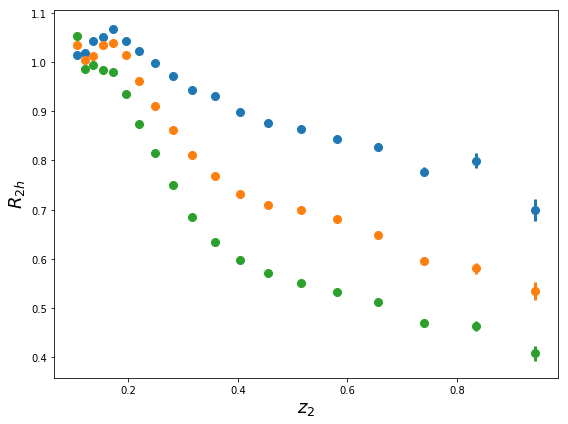

In [9]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target], df['GiBUU_D_hadron'], 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.1,maxz=1.0,nbins=20)
    plt.errorbar(x,r,yerr=err,label='This work,  %s'%target,fmt='o',ms=8)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)


plt.tight_layout()
plt.savefig('Rh.png')
#plt.xlim([0.05,0.5])

#plt.xscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

## Both pi+ and pi-

Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001


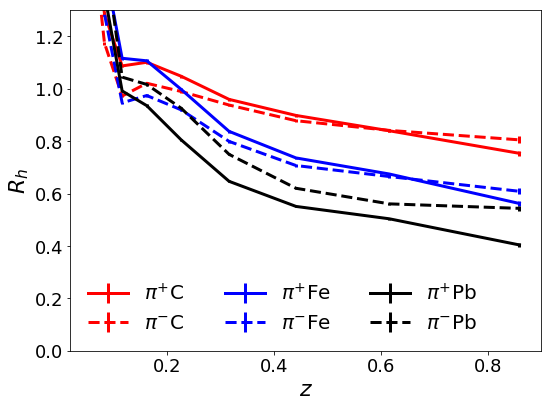

In [36]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

# momentum

Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001
Number of electron A 1000001
Number of electron D 1000001


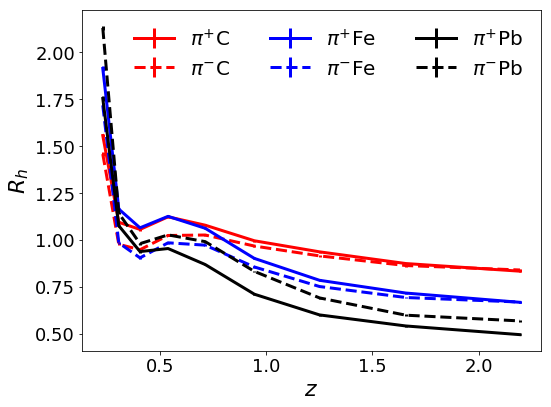

In [55]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.2,maxz=2.5,nbins=10,variable='P')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'],
                        minz=0.2,maxz=2.5,nbins=10,variable='P')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    

plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
#plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

Q2>1.85 and Q2<2.40 and Nu>2.20 and Nu<3.00
Number of electron A 27997
Number of electron D 27798


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Number of electron A 27997
Number of electron D 27798
pi+ [       nan 1.58189588 1.13915234 1.14903432 1.04017267 1.04733265
 0.92222573 0.78448541 0.72536284]
pi- [       nan 1.5329317  0.99205209 0.94231287 0.95600564 0.94073629
 0.89163919 0.89442967 0.83724955]
[       nan 1.03194153 1.14827876 1.21937665 1.08804031 1.11331164
 1.03430372 0.87707892 0.86636396]
Number of electron A 27895
Number of electron D 27798
Number of electron A 27895
Number of electron D 27798
pi+ [       nan 2.01761293 1.20172006 1.09218501 1.02534954 0.87423399
 0.7378559  0.63285429 0.56930971]
pi- [       nan 1.78407598 0.94467314 0.93030854 0.92248001 0.80410074
 0.69534864 0.65177562 0.63023326]
[       nan 1.13090079 1.27210143 1.17400298 1.11151411 1.08721949
 1.06113086 0.97096957 0.90333175]
Number of electron A 27959
Number of electron D 27798
Number of electron A 27959
Number of electron D 27798
pi+ [       nan 1.81843566 1.01628916 0.89975744 0.80220737 0.69259439
 0.51079755 0.46362368 0.404140

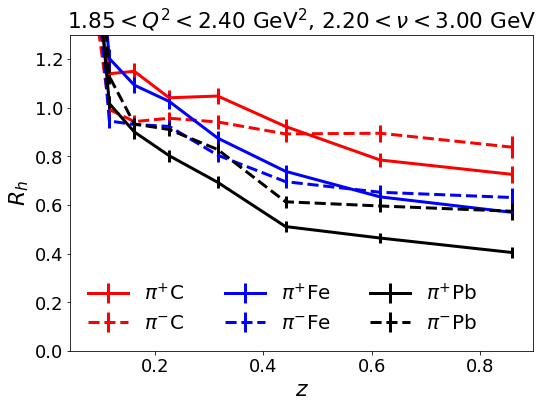

In [52]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
print event_selection

for target in ['C','Fe','Pb']:
    r_pip, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r_pip,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r_pim, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.05,maxz=1.0,nbins=10)
    
    plt.errorbar(x,r_pim,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    
    print 'pi+', r_pip
    print 'pi-', r_pim
    print np.true_divide(r_pip,r_pim)

plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$, %2.2f$<\nu<$%2.2f GeV'%(minQ2,maxQ2,minNu,maxNu))
    
plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

Q2>1.85 and Q2<2.40 and Nu>2.20 and Nu<3.00
Number of electron A 27997
Number of electron D 27798
Number of electron A 27997
Number of electron D 27798
Number of electron A 27895
Number of electron D 27798
Number of electron A 27895
Number of electron D 27798
Number of electron A 27959
Number of electron D 27798
Number of electron A 27959
Number of electron D 27798


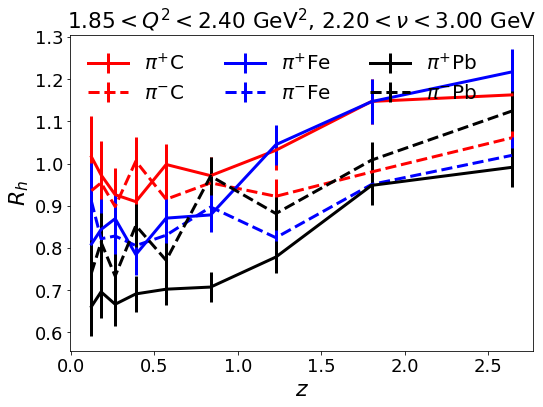

In [50]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
print event_selection

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.1,maxz=np.pi,nbins=10,variable='phi_pq')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.1,maxz=np.pi,nbins=10,variable='phi_pq')
    
    plt.errorbar(x,r,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    


plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$, %2.2f$<\nu<$%2.2f GeV'%(minQ2,maxQ2,minNu,maxNu))
    
plt.xlabel('$z$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
#plt.ylim([0.0,1.3])

plt.tight_layout()
plt.savefig('Rh.png')

Q2>1.85 and Q2<2.40
Number of electron A 228480
Number of electron D 228135
pi+ [1.80478365 1.38380985 1.16855848 1.0467587  1.05306336 1.08972059
 1.11424959 1.12124368 1.0668379  1.06183954 1.04491521 0.97919208
 0.96651904 0.94539202 0.88187345 0.89459243 0.87130842 0.82307102
        nan]
pi- [2.54114224 1.66272827 1.2486739  1.03288008 0.99442525 0.9955121
 1.03602211 1.02990313 1.03888731 0.95723381 0.89623326 0.80769378
 0.72473692 0.68216863 0.6161385  0.58594594 0.59181959 0.5718263
        nan]
[0.71022535 0.83225255 0.9358396  1.01343682 1.05896684 1.09463319
 1.07550754 1.08868849 1.02690436 1.10927918 1.16589648 1.21233083
 1.33361363 1.38586265 1.43129093 1.52674908 1.47225341 1.43937244
        nan]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Number of electron A 228390
Number of electron D 228135
pi+ [2.33935408 1.61333995 1.27080786 1.09202094 1.10590672 1.1100772
 1.11660175 1.13981223 1.08330156 1.03792431 0.94295606 0.85974052
 0.82448244 0.7774256  0.74664018 0.73586532 0.71416572 0.65341774
        nan]
pi- [2.54114224 1.66272827 1.2486739  1.03288008 0.99442525 0.9955121
 1.03602211 1.02990313 1.03888731 0.95723381 0.89623326 0.80769378
 0.72473692 0.68216863 0.6161385  0.58594594 0.59181959 0.5718263
        nan]
[0.92059155 0.97029682 1.01772598 1.0572582  1.11210644 1.11508157
 1.07777792 1.1067179  1.04275175 1.0842955  1.0521324  1.0644387
 1.13762997 1.13963845 1.21180576 1.25585871 1.20672875 1.14268569
        nan]
Number of electron A 227742
Number of electron D 228135
pi+ [2.17161661 1.46958871 1.18095865 0.98009889 0.95769374 0.95949302
 0.95427413 0.96140058 0.90863985 0.8400229  0.75486083 0.67015947
 0.6168306  0.59311476 0.55082262 0.5580367  0.53349926 0.48609093
        nan]
pi- [2.54114224 1.662728

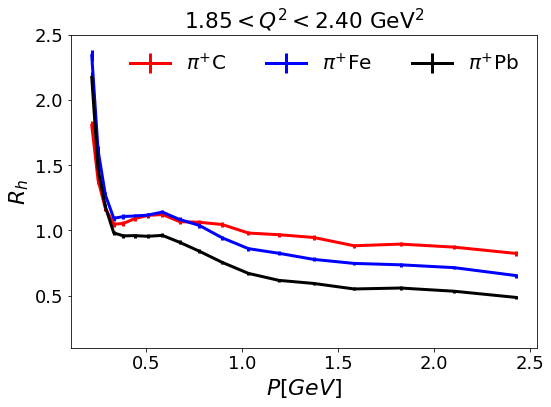

In [65]:
fig = plt.figure(figsize=(8,6))


colors = {}
colors['C'] = 'red'
colors['Fe'] = 'blue'
colors['Pb']= 'black'

minQ2 = 1.85
maxQ2 = 2.40
minNu = 2.2
maxNu = 3.0

#event_selection = 'Q2>%2.2f and Q2<%2.2f and Nu>%2.2f and Nu<%2.2f'%(minQ2,maxQ2,minNu,maxNu)
event_selection = 'Q2>%2.2f and Q2<%2.2f'%(minQ2,maxQ2)

print event_selection

for target in ['C','Fe','Pb']:
    r_pip, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==211'), df['GiBUU_D_hadron'].query('pid==211'), 
                        df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
                        minz=0.2,maxz=3.0,nbins=20,variable='P')
    
    plt.errorbar(x,r_pip,yerr=err,label=r'$\pi^{+}$'+'%s'%target,fmt='-',ms=8,color=colors[target])
    
    
    #r_pim, err,x = getRatio(df['GiBUU_%s_hadron'%target].query('pid==-211'), df['GiBUU_D_hadron'].query('pid==-211'), 
    #                    df['GiBUU_%s_electron'%target], df['GiBUU_D_electron'], event_cut = event_selection,
    #                    minz=0.2,maxz=3.0,nbins=20,variable='P')
    
    #plt.errorbar(x,r_pim,yerr=err,label=r'$\pi^{-}$'+'%s'%target,fmt='-',ms=8,ls='--',color=colors[target])
    
    print 'pi+', r_pip
    print 'pi-', r_pim
    print np.true_divide(r_pip,r_pim)

plt.title(r'%2.2f$<Q^{2}<$%2.2f GeV$^{2}$'%(minQ2,maxQ2))
    
plt.xlabel('$P [GeV]$',fontsize=22)
plt.ylabel('$R_{h}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.1,2.5])
#plt.xscale('log')
plt.tight_layout()
plt.savefig('Rh.png')

In [ ]:
## Plot the 

## Theory only

In [ ]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'])
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.xlim([0.06,0.5])
plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

## Result compared with GiBUU

In [ ]:
fig = plt.figure(figsize=(8,6))


for i,target in enumerate(['C','Fe']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='z_asso',minz=0.07,maxz=0.5#,pair_cut='and z_asso>0.1'
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='z_asso',minz=0.07,maxz=0.5#,pair_cut='and z_asso>0.1'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='Hermes, N',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='Hermes, Kr',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='Hermes, Xe',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.text(0.20, 1.2, 'CLAS \nINTERNAL', fontsize=30)

plt.legend(frameon=False,ncol=3,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')


## Results vs GiBUU (mass)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='mass',minz=0.4,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='mass',minz=0.4,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=False,ncol=2)
plt.xlabel('Dipion mass (GeV)',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)

#plt.ylim([0.0,1.2])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_mass.png')
plt.savefig('MainResult_withGiBUU_mass.pdf')

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='dipion_pt',minz=0.05,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='dipion_pt',minz=0.0,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)


plt.legend(frameon=False)
plt.xlabel('Dipion transverse momentum (GeV)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('MainResult_withGiBUU_mass.png')

## Results vs GiBUU (momentum P2)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='P_asso',minz=0.250,maxz=1.0,nbins=7
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='P_asso',minz=0.250,maxz=1.0,nbins=7
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

#plt.xscale('log')
plt.legend(frameon=False)
plt.xlabel('$P_{2}$ (GeV)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Momentum.png')

## Results vs GiBUU (ztot)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='z_tot',minz=0.56,maxz=1.0,nbins=15
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='z_tot',minz=0.56,maxz=1.0,nbins=15
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.xscale('log')
plt.legend(frameon=False)
plt.xlabel('$z_{tot}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Momentum.png')

## Results vs GiBUU (Nu)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='Nu',minz=2.4,maxz=5,nbins=5,pair_cut='and z_asso>0.1'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='Nu',minz=2.4,maxz=5,nbins=5,pair_cut='and z_asso>0.1'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.legend(frameon=False)
plt.xlabel('Nu (GeV)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
#plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Nu.png')

## Results vs GiBUU (Q2)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='Q2',minz=1.0,maxz=4.0,nbins=8,pair_cut='and z_asso>0.1'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='Q2',minz=1.0,maxz=4.0,nbins=8,pair_cut='and z_asso>0.1'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.legend(frameon=False)
plt.xlabel('$Q^{2}$ (GeV$^{2}$)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
#plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Nu.png')

## R2h in mass bins

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(16,6), gridspec_kw={'hspace': 0, 'wspace':0})


mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['legend.fontsize']= 15

for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass<0.6 and mass>0.3')
    axs[0].errorbar(x,r,yerr=err,label='%s'%target)
axs[0].set_title('0.3< $M_{\pi\pi}$ <0.6 GeV',fontsize=16)
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass<0.6 and mass>0.3')
    axs[0].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[0].axhline(y=1.0,color='black',linestyle='--')
axs[0].legend(frameon=False)
plt.xlim([0.0,0.5])

for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass>0.6 and mass<1.0')
    axs[1].errorbar(x,r,yerr=err,label='%s'%target)
axs[1].set_title('0.6< $M_{\pi\pi}$ <1.0 GeV',fontsize=16)
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass>0.6 and mass<1.0')
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[1].legend(frameon=False)
plt.xlim([0.0,0.5])


for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass>1.0 and mass<1.5')
    axs[2].errorbar(x,r,yerr=err,label='%s'%target)
axs[2].set_title('1.0< $M_{\pi\pi}$ <1.5 GeV',fontsize=16)
for target in ['C','Fe']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass>1.0 and mass<1.5')
    axs[2].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[2].axhline(y=1.0,color='black',linestyle='--')
axs[2].legend(frameon=False)
plt.xlim([0.0,0.5])
plt.ylim([0.5,2.5])



axs[0].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[2].xaxis.set_label_text('$z_{2}$',fontsize=18)

axs[0].yaxis.set_label_text('$R_{2h}$',fontsize=18)

plt.tight_layout()
plt.savefig('R2h_massdependence.png')
plt.show()

## Compare results with and without z_tot<0.8 cut

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='z_asso')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                          )
    axs[0].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)

    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='z_asso',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                         pair_cut=' and z_tot<0.80')
    axs[1].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)
    
    
axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[0].axhline(y=1.0,color='black',linestyle='--')

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('ExclusiveCutVariation.png')
plt.show()

## Checking the dependency of the ratios on varios things like the charged of leading pion, subleading pion; Q2 and Nu

In [ ]:

for target in ['C','Fe','Pb']:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})
  
    printPairBreakdown(df['%s'%target])

    ##Negative associated hadron
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid>0 and z<0.7', pair_cut='and pid_asso>0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, +/+'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target], trig_cut = 'pid<0 and z<0.7',pair_cut='and pid_asso>0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, -/+'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid>0 and z<0.7', pair_cut='and pid_asso<0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, +/-'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    #r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
    #                      df_trigger['D_%s_trigger'%target], trig_cut = 'pid<0',pair_cut='and pid_asso<0')
    #axs[0].errorbar(x,r,yerr=err,label='%s, -/-'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    
    ## no charge cut
    #r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
    #                      df_trigger['D_%s_trigger'%target], minz=0.07)
    #axs[0].errorbar(x,r,yerr=err,label='%s, all'%target,fmt='o',ms=8,lw=3,capsize=5)  


    ##GiBUU negative trigger
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'], pair_cut='and pid_asso<0')                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi- asso'%target,ms=8,lw=3,capsize=5)
    
    ##GiBUU positive trigger
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'], pair_cut='and pid_asso>0')                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi+ asso'%target,ms=8,lw=3,capsize=5)
    
    ##GiBUU all hadrons
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'])                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, all'%target,ms=8,lw=3,capsize=5)
    
    plt.ylim([0.0,1.0])


    axs[1].axhline(y=1.0,color='black',linestyle='--')
    axs[0].axhline(y=1.0,color='black',linestyle='--')

    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)


    plt.savefig('ConsistencyCharge_%s.png'%target)
    plt.show()
    plt.clf()

## R_2h as a function of theta

In [ ]:
plt.hist(df['C'].query('pid>0')['theta_lab_asso'],bins=100,alpha=0.5,label='positive trigger')
plt.hist(df['C'].query('pid<0')['theta_lab_asso'],bins=100,alpha=0.5,label='negative trigger')
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [25,40,55,80]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for target in ['Fe']:
    for j, ibin in enumerate(bins):

        pair_cut = 'and theta_lab_asso>%2.2f and theta_lab_asso<=%2.2f'%(ibin[0],ibin[1])
        label = '%2.0f$<\Theta<$%2.0f, D'%(ibin[0],ibin[1])

    
    ##Positive trigger
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid>0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[0].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
        ##negative trigger
        
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid<0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[1].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
axs[0].legend(frameon=False,fontsize=12,ncol=2)
axs[1].legend(frameon=False,fontsize=12,ncol=1)    




## z2 distribution breakdown for pi+ and pi- for all nuclei

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('z>0.5 and pid_asso>0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('z>0.5 and pid_asso<0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')

# z distribution of triggers by charge

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid>0')['z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid<0')['z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')

## Distributions


In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s_trigger'%target]['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s_trigger'%target]['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{2}$',fontsize=15)
axs[1].xaxis.set_label_text('$z_{2}$',fontsize=15)

axs[0].yaxis.set_label_text("normalized units", fontsize=15)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['Nu'],bins=50,normed=True,range=(2.0,5.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['Nu'],bins=50,normed=True,range=(2.0,5.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Nu (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Nu (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['Q2'],bins=50,normed=True,range=(1.0,4.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['Q2'],bins=50,normed=True,range=(1.0,4.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)
axs[1].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['z_tot'],bins=50,normed=True,range=(0.5,1.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['z_tot'],bins=50,normed=True,range=(0.5,1.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{tot}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{tot}$',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['mass'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['mass'],bins=50,normed=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
for target in ['C','Fe','Pb']:
    y, x = np.histogram(df_trigger['%s_trigger'%target]['z'], bins=100,range =(0.5,1.0))
    y_D, x = np.histogram(df_trigger['D_%s_trigger'%target]['z'], bins=100,range =(0.5,1.0))
    x = (x[:-1] + x[1:])/2.0
    ratio = np.true_divide(y,y_D)
    plt.plot(x,ratio,label=target)

plt.xlabel('z')
plt.ylabel('ratio to deuterium')
plt.legend(frameon=False)
plt.show()
plt.savefig('Triggers_z1distributions_RatioToD.png')

In [ ]:
fig = plt.figure( figsize=(18, 4))

for i, target in enumerate(['C','Fe','Pb']):
    plt.subplot(1,3,i+1)
    plt.hist(df_trigger['%s_trigger'%target]['z'], bins=100,range =(0.5,1.0),histtype='step', label=target)
    plt.hist(df_trigger['D_%s_trigger'%target]['z'], bins=100,range =(0.5,1.0),histtype='step',label='D (%s)'%target)

    plt.ylabel('Number of pions',fontsize=13)
    plt.xlabel('$z_{1}$',fontsize=13)
    plt.legend(frameon=False)    

plt.savefig('Triggers_z1distributions.png')

In [ ]:
plt.hexbin(df_trigger['D_trigger']['Q2'],df_trigger['D_trigger']['Nu'], cmap='inferno')


In [ ]:
plt.hexbin(df_trigger['GiBUU_D_trigger']['Q2'],df_trigger['GiBUU_D_trigger']['Nu'],cmap='inferno')
